## Comparison of two GLMMs for integrating fixed effects out

In [2]:
using Revise, DelimitedFiles

In [3]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating environment at `~/GIT/susie-glmm/SuSiEGLMM.jl/Project.toml`


In [4]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM

In [5]:
using SuSiEGLMM

┌ Info: Precompiling SuSiEGLMM [9b1f91f2-0b73-4b7e-a057-f3f9c7f13fe1]
└ @ Base loading.jl:1342


In [6]:
@__DIR__

"/Users/jeankim/GIT/susie-glmm/SuSiEGLMM.jl/test"

In [7]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

#empirical grm
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

  0.867075 seconds (6.06 M allocations: 214.551 MiB, 17.76% gc time, 35.65% compilation time)


In [8]:
Seed(124)

In [9]:
T,S = svdK(K0;LOCO=false) 

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787221 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479865 … 0.001685475850207209 -0.020019442310487214; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

In [11]:
X1= (X.-mean(X,dims=2))./std(X,dims=2)
n,p = size(X1)

L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 


In [81]:
(n,p)

(503, Plot{Plots.GRBackend() n=2})

In [51]:
# data preparation
    τ2= 1.5  # true τ²

#for j = 1:B
    b_true[1]= randn(1)[1] 

    g=rand(MvNormal(τ2*K0)) #grm
    
    #generating binary outcome
    Y1=logistic.(X1*b_true+g) .>rand(n);  Y1=convert(Vector{Float64},Y1);
       
    X₀=ones(n,1); #covariates(intercepts)

In [52]:
 # transforming data         
     Xt, Xt₀, y1 = SuSiEGLMM.rotate(Y1,X1,X₀,T)   
#      y1= SuSiEGLMM.rotateY(Y1,T)

#initial values
    τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

26-element Vector{Float64}:
 0.0009765625
 0.0013810679320049757
 0.001953125
 0.0027621358640099515
 0.00390625
 0.005524271728019903
 0.0078125
 0.011048543456039806
 0.015625
 0.02209708691207961
 0.03125
 0.04419417382415922
 0.0625
 0.08838834764831845
 0.125
 0.1767766952966369
 0.25
 0.3535533905932738
 0.5
 0.7071067811865476
 1.0
 1.4142135623730951
 2.0
 2.8284271247461903
 4.0
 5.656854249492381

In [53]:
b_true[1] # true b

0.5379465462785361

In [54]:
       # setting initial values
        Σ0= 2(cov(Xt₀)+I) # avoid sigularity when only with intercept
        sig0=SuSiEGLMM.getXX('N',Σ0,'T',Xt₀)
        β̂0=SuSiEGLMM.getXy('N',sig0,y1)
     

1-element Vector{Float64}:
 -22.000000000000114

In [56]:
   for j in eachindex(τ²)
    
        ξ0 =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β̂0 ).^2+ Diagonal(SuSiEGLMM.getXX('N',Xt₀,'N',sig0).+τ²[j]*S)*ones(n))
    #Peter's version
       @time init= SuSiEGLMM.init(y1,Xt₀,S,ξ0,τ²[j],Σ0;tol=tol)
        out1=readdlm(joinpath(@__DIR__,"est_elbocomp.txt"))
        writedlm("P_elbo+true$(τ2)_$(τ²[j]).txt",out1)
    end

19
  0.460865 seconds (2.51 k allocations: 631.956 MiB, 18.55% gc time)
19
  0.587093 seconds (2.62 k allocations: 631.965 MiB, 40.41% gc time)
19
  0.503244 seconds (2.62 k allocations: 631.965 MiB, 31.25% gc time)
19
  0.374180 seconds (2.62 k allocations: 631.965 MiB, 12.42% gc time)
19
  0.382007 seconds (2.62 k allocations: 631.965 MiB, 15.05% gc time)
19
  0.374238 seconds (2.62 k allocations: 631.965 MiB, 13.18% gc time)
19
  0.412386 seconds (2.62 k allocations: 631.965 MiB, 12.96% gc time)
19
  0.377165 seconds (2.62 k allocations: 631.965 MiB, 13.35% gc time)
19
  0.376230 seconds (2.62 k allocations: 631.965 MiB, 13.70% gc time)
19
  0.396843 seconds (2.62 k allocations: 631.965 MiB, 13.90% gc time)
19
  0.466059 seconds (2.62 k allocations: 631.964 MiB, 13.93% gc time)
19
  0.414175 seconds (2.62 k allocations: 631.964 MiB, 12.18% gc time)
19
  0.393443 seconds (2.62 k allocations: 631.964 MiB, 14.39% gc time)
19
  0.429490 seconds (2.62 k allocations: 631.964 MiB, 12.91% g

In [57]:
   for j in eachindex(τ²)     
       ξ0 =sqrt.(SuSiEGLMM.getXy('N',Xt₀,β̂0 ).^2+ Diagonal(SuSiEGLMM.getXX('N',Xt₀,'N',sig0).+τ²[j]*S)*ones(n))
#My version
    @time init1= emNull(y1,Xt₀,S,τ²[j],ξ0,Σ0;tol=tol)
        out=readdlm(joinpath(@__DIR__,"est_elbo1.txt"))
        writedlm("H_elbo+true$(τ2)_$(τ²[j]).txt",out)
    end

18
  0.259489 seconds (2.08 k allocations: 384.857 MiB, 15.41% gc time)
18
  0.254369 seconds (2.19 k allocations: 384.867 MiB, 15.25% gc time)
18
  0.251839 seconds (2.19 k allocations: 384.866 MiB, 10.14% gc time)
18
  0.256834 seconds (2.19 k allocations: 384.866 MiB, 16.06% gc time)
18
  0.259744 seconds (2.19 k allocations: 384.866 MiB, 14.96% gc time)
18
  0.261886 seconds (2.19 k allocations: 384.866 MiB, 14.64% gc time)
18
  0.245668 seconds (2.19 k allocations: 384.866 MiB, 10.56% gc time)
18
  0.252697 seconds (2.19 k allocations: 384.866 MiB, 15.35% gc time)
18
  0.254850 seconds (2.19 k allocations: 384.866 MiB, 14.93% gc time)
18
  0.250561 seconds (2.19 k allocations: 384.866 MiB, 10.45% gc time)
18
  0.254061 seconds (2.19 k allocations: 384.866 MiB, 15.07% gc time)
18
  0.273243 seconds (2.19 k allocations: 384.866 MiB, 14.71% gc time)
18
  0.281287 seconds (2.19 k allocations: 384.866 MiB, 14.38% gc time)
18
  0.284003 seconds (2.19 k allocations: 384.866 MiB, 10.80% g

### Results: τ2= 0.1 

With true parameters `b=-0.308322`, `τ²=0.1`, ELBOs and τ² are tracked and compared between two versions. Peter's version is 
labelled as `P_glmm`, and mine as `H_glmm`.  Both results coincide each other completely.  Estimaties by this sample data shows the optimal τ² is much smaller than the true τ², so that the both implementations show all ELBOs increase from the beginning. 

In [25]:
using Plots

In [23]:
#print out last several ouputs of τ²'s and elbo's for small initial τ² less than the true τ2=0.1
for j=3
    display(readdlm("P_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]])
end

140×2 Matrix{Float64}:
 0.00195312  -727.098
 0.00195311  -686.014
 0.00195311  -665.556
 0.0019531   -653.34
 0.0019531   -645.24
 0.00195309  -639.49
 0.00195309  -635.207
 0.00195308  -631.9
 0.00195308  -629.277
 0.00195307  -627.149
 0.00195307  -625.392
 0.00195306  -623.921
 0.00195306  -622.673
 ⋮           
 0.00195245  -612.263
 0.00195244  -612.263
 0.00195244  -612.263
 0.00195243  -612.263
 0.00195243  -612.263
 0.00195242  -612.262
 0.00195241  -612.262
 0.00195241  -612.262
 0.0019524   -612.262
 0.0019524   -612.262
 0.00195239  -612.262
 0.00195239  -612.262

In [24]:
for j=3
    display(readdlm("H_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]])
end

140×2 Matrix{Float64}:
 0.00195312  -727.098
 0.00195311  -686.014
 0.00195311  -665.556
 0.0019531   -653.34
 0.0019531   -645.24
 0.00195309  -639.49
 0.00195309  -635.207
 0.00195308  -631.9
 0.00195308  -629.277
 0.00195307  -627.149
 0.00195307  -625.392
 0.00195306  -623.921
 0.00195306  -622.673
 ⋮           
 0.00195245  -612.263
 0.00195244  -612.263
 0.00195244  -612.263
 0.00195243  -612.263
 0.00195243  -612.263
 0.00195242  -612.262
 0.00195241  -612.262
 0.00195241  -612.262
 0.0019524   -612.262
 0.0019524   -612.262
 0.00195239  -612.262
 0.00195239  -612.262

In [26]:
P1= readdlm("P_elbo+true$(τ2)_$(τ²[1]).txt")[:,[1,end]];
H1=readdlm("H_elbo+true$(τ2)_$(τ²[1]).txt")[:,[1,end]];

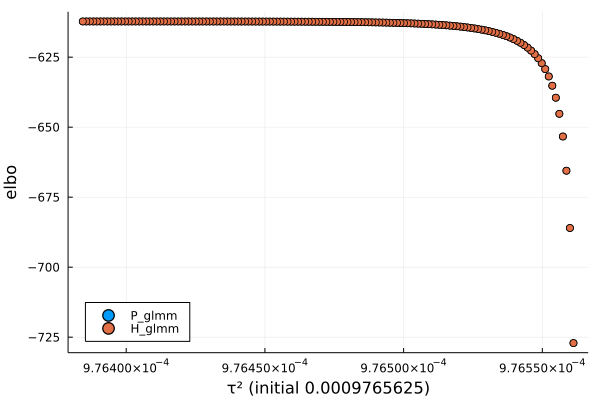

In [29]:
scatter(P1[:,1],P1[:,end],label="P_glmm", xlab="τ² (initial $(τ²[1]))", ylab="elbo",legend=:bottomleft)
scatter!(H1[:,1],H1[:,end],label="H_glmm")

In [37]:
τ²[end]

5.656854249492381

In [39]:
P15=readdlm("P_elbo+true$(τ2)_$(τ²[15]).txt")[:,[1,end]];
P26=readdlm("P_elbo+true$(τ2)_$(τ²[end]).txt")[:,[1,end]];
H15=readdlm("H_elbo+true$(τ2)_$(τ²[15]).txt")[:,[1,end]];
H26=readdlm("H_elbo+true$(τ2)_$(τ²[end]).txt")[:,[1,end]];

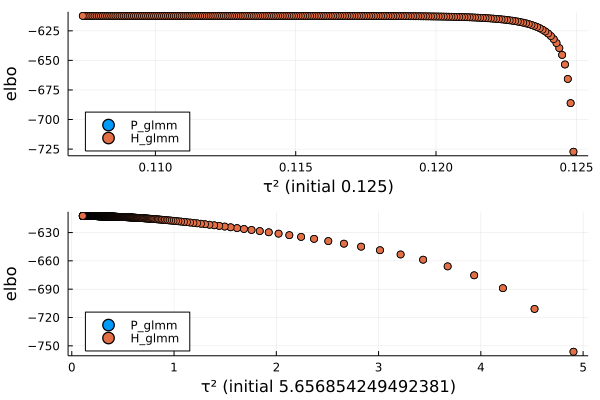

In [42]:
p=scatter(P15[:,1],P15[:,end],label="P_glmm",xlab="τ² (initial $(τ²[15]))",ylab="elbo",legend=:bottomleft)
scatter!(H15[:,1],H15[:,end],label="H_glmm")
h=scatter(P26[:,1],P26[:,end],label="P_glmm",xlab="τ² (initial $(τ²[end]))",ylab="elbo",legend=:bottomleft)
scatter!(H26[:,1],H26[:,end],label="H_glmm")
plot(p,h,layout=@layout[a ;b])

In [44]:
est=zeros(26,2);
for j in eachindex(τ²)
    est[j,:]= readdlm("H_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]][end,:]
end

est

26×2 Matrix{Float64}:
 0.000976384  -612.261
 0.00138071   -612.262
 0.00195239   -612.262
 0.00276062   -612.262
 0.00390311   -612.262
 0.00551768   -612.263
 0.00779843   -612.264
 0.0110179    -612.265
 0.0155568    -612.268
 0.0219415    -612.271
 0.030886     -612.277
 0.043324     -612.286
 0.0603602    -612.301
 0.0829799    -612.326
 0.107412     -612.358
 0.107689     -612.358
 0.107684     -612.358
 0.107694     -612.358
 0.107648     -612.358
 0.10765      -612.358
 0.107668     -612.358
 0.10768      -612.358
 0.107695     -612.358
 0.107697     -612.358
 0.10769      -612.358
 0.107658     -612.358

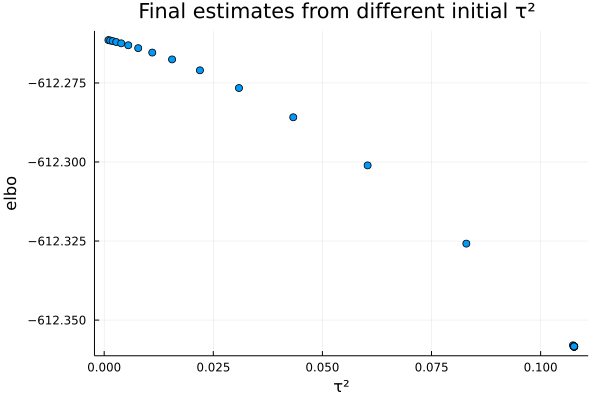

In [50]:
scatter(est[:,1],est[:,2],xlab="τ²",ylab="elbo",label="", title="Final estimates from different initial τ² ")

### Results: τ2= 1.5

Sample data is generated by the following true parameters: `τ²=1.5`, `b =0.5379465`.  Depending on the sampled data, ELBO may not 
increase from the beginning compring with the results in the `debug_glmm` notebook.  However, ELBO should increase near the solution 
to the log-likelihood (or ELBO), as the plots show, which is why sufficiently small initial values presumuably closer to the solution are chosen 
in frequentist optimization problems to avoid estimates fluctuating.   

In addition, the results from mine `H_glmm` not only concide those from Peter's version `P_glmm`, but it is faster and computationally 
more efficient than his because `λ(ξ)` is not integrated out, so that the covariance matrix of the posterior `g` is diagonal.

In [69]:
τ²[2]

0.0013810679320049757

In [71]:
#print out last several ouputs of τ²'s and elbo's for small initial τ² less than the true τ2
for j=1
    display(readdlm("P_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]])
end

18×2 Matrix{Float64}:
 0.000976571  -661.968
 0.00097658   -627.158
 0.000976589  -613.656
 0.000976598  -607.831
 0.000976607  -605.232
 0.000976616  -604.068
 0.000976625  -603.553
 0.000976634  -603.335
 0.000976643  -603.247
 0.000976651  -603.213
 0.00097666   -603.198
 0.000976669  -603.192
 0.000976678  -603.19
 0.000976687  -603.189
 0.000976696  -603.188
 0.000976705  -603.188
 0.000976714  -603.188
 0.000976723  -603.188

In [70]:
for j=2
    display(readdlm("H_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]])
end

18×2 Matrix{Float64}:
 0.00138109  -661.967
 0.0013811   -627.157
 0.00138112  -613.655
 0.00138114  -607.83
 0.00138116  -605.231
 0.00138117  -604.067
 0.00138119  -603.553
 0.00138121  -603.334
 0.00138123  -603.247
 0.00138125  -603.212
 0.00138126  -603.198
 0.00138128  -603.191
 0.0013813   -603.189
 0.00138132  -603.188
 0.00138133  -603.187
 0.00138135  -603.187
 0.00138137  -603.187
 0.00138139  -603.187

In [72]:
P1= readdlm("P_elbo+true$(τ2)_$(τ²[1]).txt")[:,[1,end]];
H1=readdlm("H_elbo+true$(τ2)_$(τ²[1]).txt")[:,[1,end]];

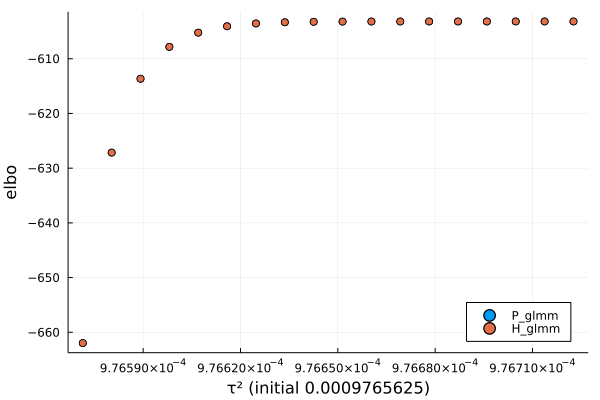

In [80]:
scatter(P1[:,1],P1[:,end],label="P_glmm", xlab="τ² (initial $(τ²[1]))", ylab="elbo",legend=:bottomright)
scatter!(H1[:,1],H1[:,end],label="H_glmm")

In [74]:
P15=readdlm("P_elbo+true$(τ2)_$(τ²[15]).txt")[:,[1,end]];
P26=readdlm("P_elbo+true$(τ2)_$(τ²[end]).txt")[:,[1,end]];
H15=readdlm("H_elbo+true$(τ2)_$(τ²[15]).txt")[:,[1,end]];
H26=readdlm("H_elbo+true$(τ2)_$(τ²[end]).txt")[:,[1,end]];

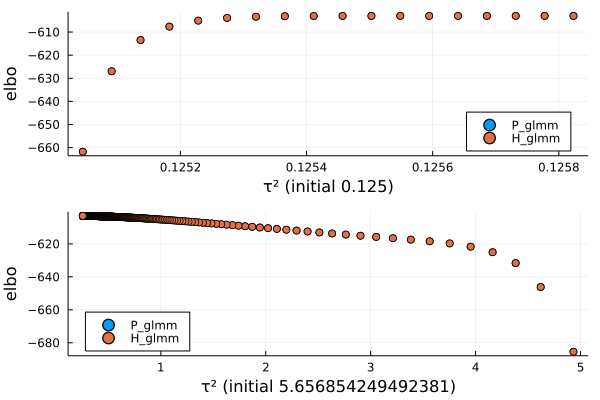

In [77]:
p=scatter(P15[:,1],P15[:,end],label="P_glmm",xlab="τ² (initial $(τ²[15]))",ylab="elbo",legend=:bottomright)
scatter!(H15[:,1],H15[:,end],label="H_glmm")
h=scatter(P26[:,1],P26[:,end],label="P_glmm",xlab="τ² (initial $(τ²[end]))",ylab="elbo",legend=:bottomleft)
scatter!(H26[:,1],H26[:,end],label="H_glmm")
plot(p,h,layout=@layout[a ;b])

In [78]:
est=zeros(26,2);
for j in eachindex(τ²)
    est[j,:]= readdlm("H_elbo+true$(τ2)_$(τ²[j]).txt")[:,[1,end]][end,:]
end

est

26×2 Matrix{Float64}:
 0.000976723  -603.188
 0.00138139   -603.187
 0.00195376   -603.185
 0.0027634    -603.183
 0.00390877   -603.181
 0.00552926   -603.177
 0.00782233   -603.172
 0.0110678    -603.165
 0.0156624    -603.155
 0.0221688    -603.141
 0.0313847    -603.123
 0.0444391    -603.099
 0.0629222    -603.069
 0.0890478    -603.034
 0.125823     -602.999
 0.177137     -602.977
 0.247422     -602.991
 0.255923     -602.996
 0.255951     -602.996
 0.255949     -602.996
 0.255913     -602.996
 0.256026     -602.996
 0.2559       -602.996
 0.255972     -602.996
 0.256001     -602.996
 0.25601      -602.996

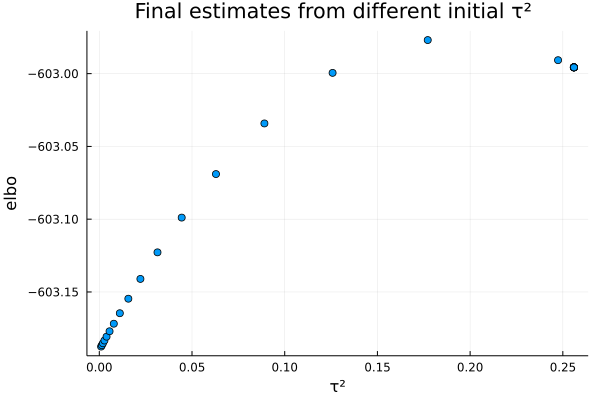

In [79]:
scatter(est[:,1],est[:,2],xlab="τ²",ylab="elbo",label="", title="Final estimates from different initial τ² ")

### Testing type I error and power

In [17]:
A=[sum(init1[j].ξ.==NaN) for j=1:B]
sum(A)

0

In [10]:
X1= (X.-mean(X,dims=2))./std(X,dims=2)
n,p = size(X1)
X₀=ones(n,1)

L=1; B=100;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 


In [33]:
Seed(124)

In [11]:
#fix true values of parameters
τ2=0.5;b_true[1]=randn(1)[1]
println(b_true[1])
init0=[]; init1=[]

#  tt=zeros(B);
#Ps=zeros(p,R); 
#  Ts1=zeros(p,B);#Ps1=zeros(p,R);
Y0=zeros(n,B);
Y1=zeros(n,B);


for j = 1:B
#     b_true[1]= randn(1)[1] # true b 
#     b_1s[j] = b_true[1]   
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    y0= logistic.(g) .>rand(n) # H0 data
    y1=logistic.(X1*b_true+g) .>rand(n)  # H1 data
    
    Y0[:,j]=y0
    Y1[:,j]=y1
    
    # Y0[:,j]=Y1
# test power
#     t0=@elapsed begin
        # implementing null glmm
        Xt, Xt₀, yt,init00= glmmNull(Y0[:,j],X1,X₀,T,S;tol=tol) #H0 data
        Xt, Xt₀, yt,init10= glmmNull(Y1[:,j],X1,X₀,T,S;tol=tol)#H1 data           
#         T0= computeT(init00,yt,Xt₀,Xt)
#         T1= computeT(init10,yt,Xt₀,Xt)
#     end
    init0=[init0;init00]
    init1=[init1;init10]
#     Ts[:,j]=T0;
#     Ts1[:,j]=T1
    # # Ps[:,j]=ccdf.(Chisq(1),T0); Ps1[:,j]=ccdf.(Chisq(1),T1)
#     tt[j]=t0
  
end

0.7611424922951856
639
654
700
1016
1037
762
564
833
636
993
1298
735
647
666
1012
783
597
673
372
389
627
1044
758
502
383
462
958
500
497
731
1363
835
461
563
834
1180
541
544
1178
893
509
674
665
1058
938
420
624
876
1308
1006
1030
614
659
453
841
911
415
659
623
688
957
1043
1299
456
501
532
720
666
842
806
1058
758
522
1179
1218
453
792
780
869
1048
658
735
1015
408
588
785
1287
716
687
617
501
407
794
618
1287
470
896
525
346
752
943
533
554
936
913
415
708
609
1029
583
1110
699
614
543
806
694
646
614
528
708
720
751
1246
447
1017
532
963
1124
1288
445
865
1029
830
615
1004
623
1020
475
874
475
947
970
636
647
702
476
678
413
439
446
687
743
915
561
614
692
650
771
1154
746
908
786
781
816
437
536
732
933
609
491
678
869
718
1122
1067
390
972
846
404
1106
387
969
636
723
320
371
469
865
964
595
1207
706
677
976
512
374
655
1057
893
768


In [12]:
 # transforming data         
     Xt = SuSiEGLMM.rotateX(X1,T) 
     Xt₀ =SuSiEGLMM.rotateX(X₀,T)
     Yt₀= SuSiEGLMM.rotateX(Y0,T)
     Yt₁ = SuSiEGLMM.rotateX(Y1,T)

503×100 Matrix{Float64}:
  -0.281742    -0.282238    -0.0372717   …   -0.298355     0.602926
  -0.409628    -0.100311    -0.0346273        0.214475     0.0878239
  -0.290235     0.34584      0.67106         -0.412391     0.253468
   0.41619      0.427546     0.505881        -0.814398     0.224555
  -0.161052     0.731624     0.00201658      -0.416737     0.404269
  -0.698879    -0.328481    -0.528237    …    0.45362      1.03773
   0.437868    -0.0231281    0.307255         0.284025     0.299547
  -0.236699    -0.203678     0.0740123        0.46705      0.216777
   0.876002    -0.439842    -0.188448        -0.103025    -0.220493
   0.481793    -0.316278    -0.162646        -0.0712136    0.317154
   0.0910624   -0.533414    -0.350506    …   -0.148654    -0.585304
   0.077311    -0.103435    -0.0453285       -0.754494    -1.00668
   0.960919     0.31032      1.28467          0.558221    -0.107002
   ⋮                                     ⋱               
   0.41874      0.464188     0.933

In [13]:
# predicted values, p̂
P̂0=zeros(n,B);P̂1=zeros(n,B);
P0=zeros(n,B); P1=zeros(n,B);
#using raw Y0, Y1
for j=1:B
        r₀ =  SuSiEGLMM.getXy('N',X₀,init0[j].β)+init0[j].μ  
        r₁ = SuSiEGLMM.getXy('N',X₀,init1[j].β)+init1[j].μ 
        P̂0[:,j] = logistic.(r₀)
        P̂1[:,j]=logistic.(r₁)
end

#using centered ones
for j=1:B
#     r0=2Yt₀[:,j].*(SuSiEGLMM.getXy('N',Xt₀,init0[j].β)+init0[j].μ)
    r0=(2Y0[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init0[j].β)+init0[j].μ)
#     r1=2Yt₁[:,j].*(SuSiEGLMM.getXy('N',Xt₀,init1[j].β)+init1[j].μ)
    r1=(2Y1[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init0[j].β)+init0[j].μ)
    P0[:,j]=logistic.(r0)
    P1[:,j]=logistic.(r1)
end
    

In [14]:
#type 1 error
#using raw Y0, Y1
α = [mean(P̂0[:,j].<0.05) for j=1:B]
ᾱ= mean(α)

#using centered ones
a=[mean(P0[:,j].<0.05) for j=1:B]
α̂ =mean(a)
# α̂ = mean(P0.<0.05)
[ᾱ α̂]

1×2 Matrix{Float64}:
 0.11  0.162207

In [15]:
a

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.4731610337972167
 0.4711729622266402
 0.0
 0.0
 0.0
 0.46520874751491054
 ⋮
 0.4691848906560636
 0.0
 0.4731610337972167
 0.0
 0.0
 0.4433399602385686
 0.0
 0.47514910536779326
 0.46520874751491054
 0.0
 0.0
 0.0

In [16]:
# power

βᶜ= [mean(P̂1[:,j].>ᾱ) for j=1:B]

[mean(βᶜ) mean(P1.>α̂)]



1×2 Matrix{Float64}:
 0.995527  0.817455

In [17]:
using Plots

In [26]:
# check distribution of min p̂ of null data for later multiple testing
a0=[minimum(P0[:,j]) for j=1:B]
sum(a0.<0.05)
a0

100-element Vector{Float64}:
 0.4037816626217196
 0.0877973246505708
 0.4396289575833822
 0.35003090089804284
 0.4007233858042563
 0.45499123712665895
 0.40528166626715134
 7.484518841576581e-5
 1.2183816962818158e-6
 0.3435634823390726
 0.39873754634369396
 0.4287054088111267
 6.595573017985115e-12
 ⋮
 2.6689768851228435e-8
 0.36187414025245423
 4.7741090901792396e-5
 0.42830654246578626
 0.2703309793853118
 5.821442205485416e-31
 0.4360366594324224
 0.0037691761704222474
 7.496914232469528e-12
 0.3581804186390928
 0.4115320493485891
 0.3906818057303441

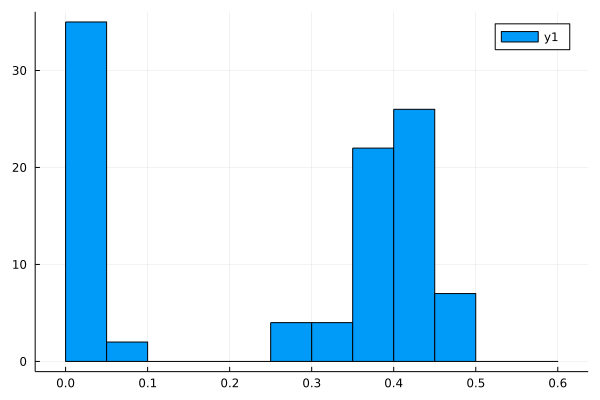

In [19]:
histogram(a0,bins=0:0.05:0.6)

In [20]:
tau0=[init0[j].τ2 for j=1:B];
tau1 =[init1[j].τ2 for j=1:B];

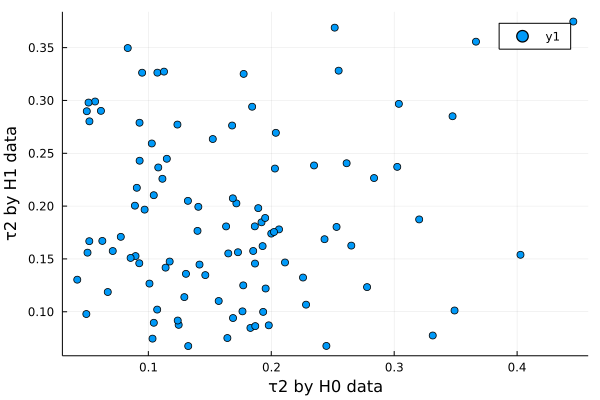

In [21]:
scatter(tau0, tau1, xlab="τ2 by H0 data", ylab="τ2 by H1 data")

In [22]:
# Debugging score test function, `computeT`
Ts=zeros(p,B);
Γ  = P1.*(1.0.-P1)
for l=1:B
        # XX=Xt₀'Diagonal(Γ)
        proj= I - X₀*(SuSiEGLMM.symXX('T',sqrt.(Γ[:,l]).*X₀)\(X₀'Diagonal(Γ[:,l])))
        # proj = I - Xt₀*(getXX('N',XX,'N',Xt₀))\XX
        G̃ = SuSiEGLMM.getXX('N',proj,'N',X1) #n x p
    
         ĝ = SuSiEGLMM.getXy('T',G̃,(Y1[:,l]-P1[:,l])).^2
         
         for j = 1:p
              Ts[j,l] = ĝ[j]/(G̃[:,j]'*(Γ[:,l].*G̃[:,j]))
           end
end

In [23]:
Ts

4000×100 Matrix{Float64}:
 51.6796      420.686      50.6925     …  40.5324       68.596
  0.390527     10.8743      1.92132        0.201273      0.0170811
  0.030188     38.7247      1.77977        4.33852       0.0511506
  0.00685239   13.5775      0.0423671      5.54015e-6    0.71422
  0.247173      3.02364     1.34467        0.692286      2.51282
  0.739463      0.320649    0.177017   …   1.8433        1.05294
  2.60826       1.58273     0.298164       3.59337       0.0971913
  0.317691      0.753472    0.459708       0.0219426     0.0442327
  0.820435      0.176801    0.0131465      2.20271       0.133871
  0.220379      9.59698     1.36182        0.00579173    1.18247
  2.56728       0.0430531   0.297279   …   0.393633      0.157325
  4.14525       2.58981     0.0606773      0.124433     12.7338
  0.235941      2.77904     0.0169555      0.937314      2.7441
  ⋮                                    ⋱                
  0.00022614   12.2564      0.273976       0.0824183     0.295009


In [24]:
 (1.0.-P̂1).*P̂1

503×100 Matrix{Float64}:
 0.0  1.82532e-6  0.232264  0.248909  …  0.224115  0.249993  7.66454e-5
 0.0  1.77036e-6  0.232214  0.249749     0.243543  0.249503  8.74695e-5
 0.0  1.64598e-6  0.219529  0.249998     0.224806  0.249998  8.3948e-5
 0.0  1.62465e-6  0.222766  0.24978      0.247049  0.249735  8.45736e-5
 0.0  1.54712e-6  0.231617  0.249111     0.246585  0.249998  8.09034e-5
 0.0  1.83566e-6  0.239231  0.243943  …  0.239134  0.249044  6.92463e-5
 0.0  1.74776e-6  0.226505  0.249498     0.247916  0.249395  8.31054e-5
 0.0  1.79833e-6  0.230469  0.249471     0.240055  0.24903   8.48486e-5
 0.0  1.86674e-6  0.234513  0.249059     0.243748  0.249892  9.43493e-5
 0.0  1.8301e-6   0.23412   0.249275     0.217838  0.249866  8.28433e-5
 0.0  1.89305e-6  0.23676   0.249855  …  0.249787  0.249923  0.000102948
 0.0  1.7697e-6   0.232349  0.249927     0.241001  0.249831  0.000113871
 0.0  1.65926e-6  0.207833  0.249985     0.247527  0.248836  9.17482e-5
 ⋮                                    

In [25]:
(1.0.-P1).*P1


503×100 Matrix{Float64}:
 0.244627  0.0980414  0.249725  0.24976   …  0.239309  0.246604  0.243672
 0.24746   0.120159   0.248619  0.249642     0.23985   0.247853  0.244311
 0.249923  0.109221   0.24877   0.23457      0.248908  0.245078  0.246867
 0.248946  0.0956409  0.24988   0.247535     0.249924  0.24989   0.24555
 0.249979  0.0806428  0.249807  0.22848      0.239385  0.249994  0.245778
 0.249311  0.129079   0.248854  0.249894  …  0.24658   0.248322  0.247231
 0.247785  0.086994   0.249843  0.248895     0.249852  0.249166  0.245287
 0.249381  0.0949504  0.247481  0.249859     0.247656  0.249959  0.242551
 0.247593  0.11435    0.248877  0.244289     0.231769  0.242173  0.245731
 0.242119  0.0780465  0.24929   0.247939     0.248519  0.249985  0.249253
 0.242361  0.116974   0.2494    0.235915  …  0.24852   0.249288  0.243293
 0.249945  0.0970981  0.246193  0.249991     0.249731  0.247079  0.245605
 0.249987  0.098347   0.24967   0.243009     0.24515   0.249674  0.24535
 ⋮             

In [108]:
[mean(a[:,1].<0.1) mean(a[:,2].<0.1)]

1×2 Matrix{Float64}:
 0.2  0.1

In [111]:
mean(a.<0.1)

0.15

In [112]:
(0.2+0.1)/2

0.15000000000000002